# Evaluation of multilog measurement

This is a template for evaluation of a multilog measurement - just copy it and adjust it to your needs. If you make general changes pleas update this template on https://github.com/nemocrys/multilog.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib widget

## Load data

Load files written by multilog.

In [2]:
multilog_output_dir = "./multilog/measdata_2022-12-08_#01"

data_files_csv = []
camera_dirs = []
for element in os.listdir(multilog_output_dir):
    if element.split(".")[-1] == "csv" and element != "metadata.csv":
        data_files_csv.append(element)
    elif os.path.isdir(f"{multilog_output_dir}/{element}"):
        camera_dirs.append(element)

print(f"Found the following directories with camera data:\n{camera_dirs}")

data = {}
for file in data_files_csv:
    df = pd.read_csv(f"{multilog_output_dir}/{file}", comment="#")
    for key in df.keys():
        if "Unnamed" in key:
            df.pop(key)
    data.update({file[:-4]: df})

print(f"Created dictionary with csv-data for:\n{list(data.keys())}")

Found the following directories with camera data:
['Optris-IP-640']
Created dictionary with csv-data for:
['DAQ-6510', 'Eurotherm', 'IFM-flowmeter', 'IGA-6-23-vis', 'IGAR-6-adv', 'Process-Condition-Logger']


## Visualize

### Overview plots of all devices

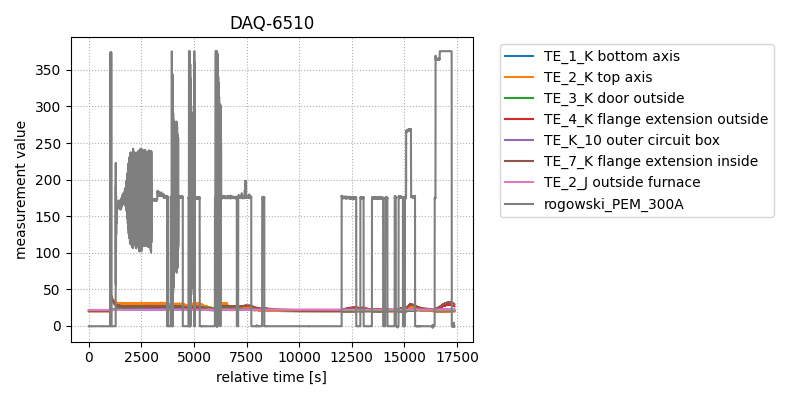

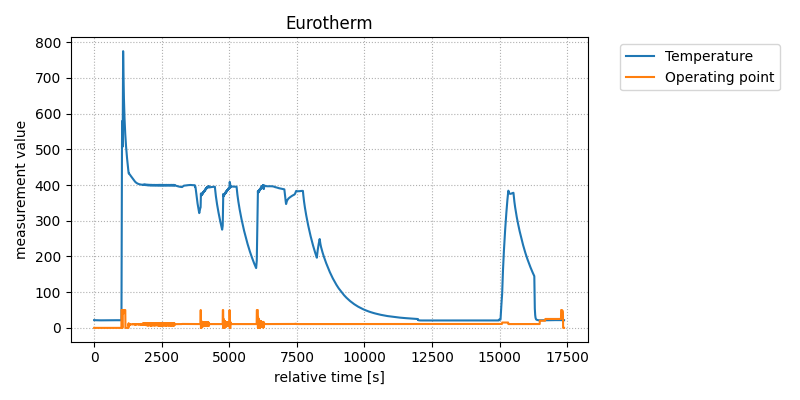

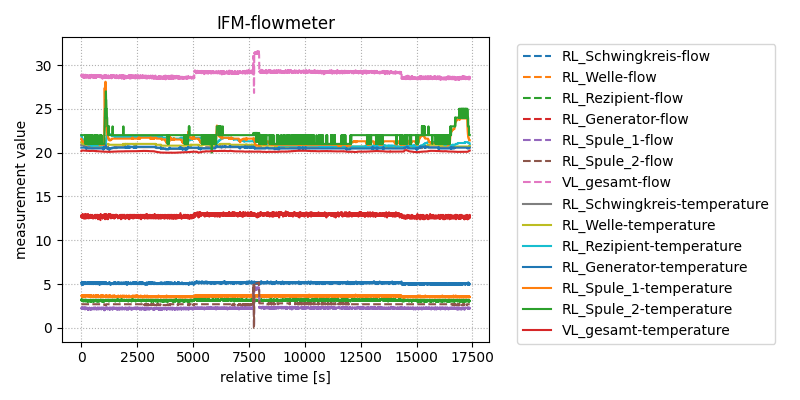

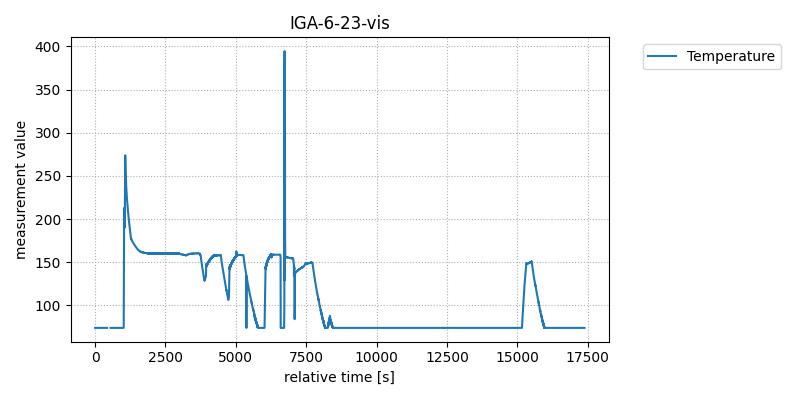

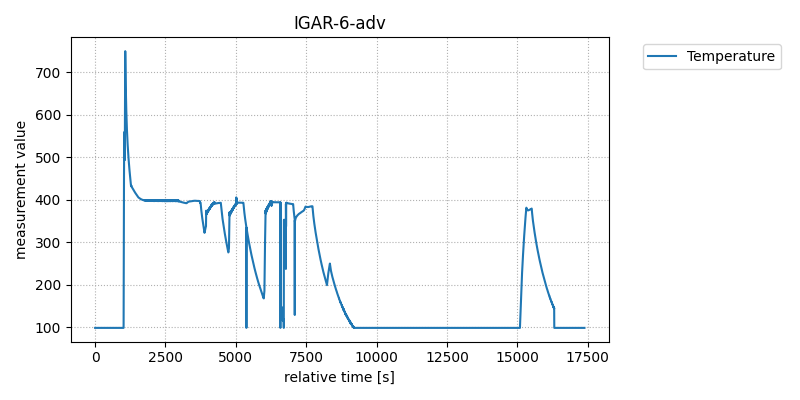

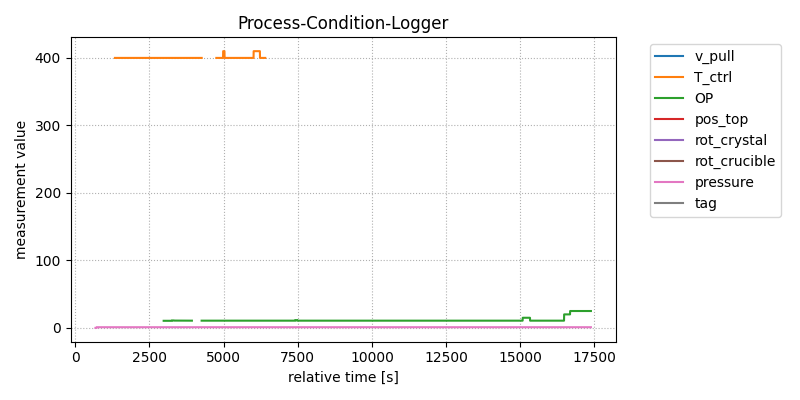

In [3]:
for device in data:
    plt.subplots(figsize=(8,4))
    plt.title(device)
    df = data[device]
    for key in df.keys():
        if not "time" in key and df.dtypes[key] == "float64":
            if "flow" in key:
                plt.plot(df["time_rel"], df[key], "--", label=key)
            else:
                plt.plot(df["time_rel"], df[key], label=key)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(linestyle=":")
    plt.xlabel("relative time [s]")
    plt.ylabel("measurement value")
    plt.tight_layout()

### Plots of selected devices and channels

In [4]:
for device in data:
    print(f"Available channels for '{device}':\n{list(data[device].keys())}")

Available channels for 'DAQ-6510':
['time_abs', 'time_rel', 'TE_1_K bottom axis', 'TE_2_K top axis', 'TE_3_K door outside', 'TE_4_K flange extension outside', 'TE_K_10 outer circuit box', 'TE_7_K flange extension inside', 'TE_2_J outside furnace', 'rogowski_PEM_300A']
Available channels for 'Eurotherm':
['time_abs', 'time_rel', 'Temperature', 'Operating point']
Available channels for 'IFM-flowmeter':
['time_abs', 'time_rel', 'RL_Schwingkreis-flow', 'RL_Welle-flow', 'RL_Rezipient-flow', 'RL_Generator-flow', 'RL_Spule_1-flow', 'RL_Spule_2-flow', 'VL_gesamt-flow', 'RL_Schwingkreis-temperature', 'RL_Welle-temperature', 'RL_Rezipient-temperature', 'RL_Generator-temperature', 'RL_Spule_1-temperature', 'RL_Spule_2-temperature', 'VL_gesamt-temperature']
Available channels for 'IGA-6-23-vis':
['time_abs', 'time_rel', 'Temperature']
Available channels for 'IGAR-6-adv':
['time_abs', 'time_rel', 'Temperature']
Available channels for 'Process-Condition-Logger':
['time_abs', 'time_rel', 'v_pull', 'T

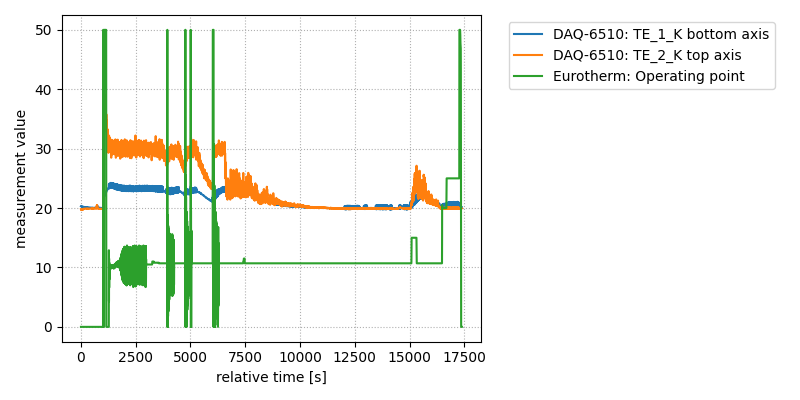

In [5]:
device_channel = [
    ["DAQ-6510", "TE_1_K bottom axis"],
    ["DAQ-6510", "TE_2_K top axis"],
    ["Eurotherm", "Operating point"],
]

plt.subplots(figsize=(8,4))
for element in device_channel:
    plt.plot(data[element[0]]["time_rel"], data[element[0]][element[1]], label=f"{element[0]}: {element[1]}")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(linestyle=":")
plt.xlabel("relative time [s]")
plt.ylabel("measurement value")
plt.tight_layout()

### IR Camera
For long measurement times loading all images may take a while. This loads only the first 10 images by default.

interactive(children=(IntSlider(value=0, description='idx', max=9), Output()), _dom_classes=('widget-interact'…

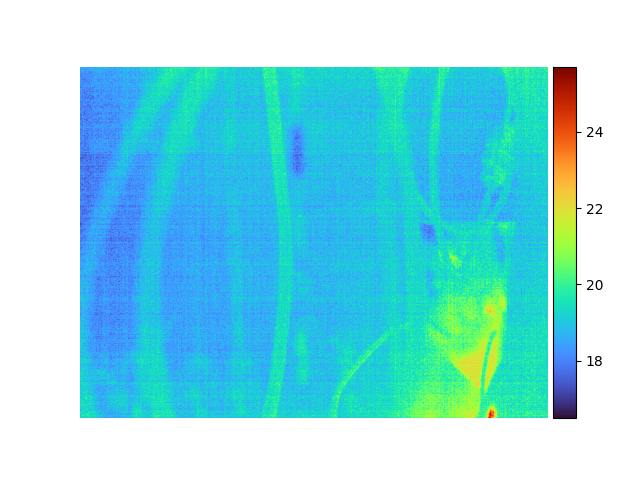

In [6]:
from ipywidgets import interact, IntSlider
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx_start = 0
idx_end = 10
if "Optris-IP-640" in camera_dirs:
    csv_files = [x for x in os.listdir(f"{multilog_output_dir}/Optris-IP-640") if ".csv" in x]
    ir_data = []
    for file in csv_files[idx_start:idx_end]:
        ir_data.append(np.loadtxt(f"{multilog_output_dir}/Optris-IP-640/{file}"))


    # line = ax.imshow(ir_data[0], cmap="turbo", aspect="equal")
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # fig.colorbar(line, cax=cax)
    # fig.tight_layout()
    fig, ax = plt.subplots()
    ax.axis("off") 
    line = ax.imshow(ir_data[0], cmap="turbo", aspect="equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(line, cax=cax)

    def plot(idx = 0):
        # fig, ax = plt.subplots()
        # ax.axis("off") 
        line = ax.imshow(ir_data[idx - idx_start], cmap="turbo", aspect="equal")
        cbar = fig.colorbar(line, cax=cax)
        # fig.tight_layout()
        fig.canvas.draw_idle()
    interact(plot, idx=IntSlider(idx_start, min=idx_start, max=idx_end-1, step=1));

## Evaluate
Use pandas to evaluate the measurements, some examples are given below.

### Compute heat fluxes

In [7]:
cp = 4200  # J/(kg K)
rho = 1000  # kg/m^3 

df = data["IFM-flowmeter"]
channels = [x.split("-")[0] for x in df.keys() if "RL" in x]
for channel in channels:
    df[f"{channel}-heat"] = df[channel+"-flow"] / 60000 * rho * cp * (df[channel+"-temperature"] - df["VL_gesamt-temperature"])

### Further evaluations

In [8]:
t_start = 1000
t_end = 2000

# filter data
df = data["IFM-flowmeter"]
df_filtered = df.loc[(t_start < df["time_rel"]) & (df["time_rel"] < t_end)]

# compute mean, min, max values
print(f"Mean heat flux: {df_filtered['RL_Spule_1-heat'].mean(): .2f} W")
print(f"Min. heat flux: {df_filtered['RL_Spule_1-heat'].min(): .2f} W")
print(f"Max heat flux: {df_filtered['RL_Spule_1-heat'].max(): .2f} W")

Mean heat flux:  287.77 W
Min. heat flux:  120.12 W
Max heat flux:  1230.46 W
